# Notebook 2: Wrangling & Feature Engineering

![Don't Reinvent the Wheel](../media/reinvent_the_wheel.png)

**Phases 4-5:** Data Wrangling & Transformation, Feature Engineering & Aggregation

**Dataset:** NYC Taxi Trip Dataset (continuing from Notebook 1)

**Focus:** Transforming and enriching data - merging datasets, working with datetime data, reshaping, and creating features for modeling.

---

**Where we are:** We've cleaned our data (Notebook 1). Now we're transforming it into a format that's ready for analysis and modeling. This is where we create the features that will help us understand patterns and make predictions.

**What we'll accomplish:**

- Merge additional data sources (zone lookup)
- Extract temporal features from datetime columns
- Create derived features (speed, fare per mile, etc.)
- Perform aggregations to understand patterns
- Calculate rolling windows for trend analysis

**Why this matters:** Raw data rarely has the features we need. Feature engineering is where domain knowledge meets data science - we create variables that capture meaningful patterns in our data.

**The big picture:**

- **Notebook 1:** Made data clean ✓
- **Notebook 2 (this one):** Make data useful (add features, reshape, aggregate)
- **Notebook 3:** Make data ready for modeling
- **Notebook 4:** Build and evaluate models

---

## Phase 4: Data Wrangling & Transformation

### Learning Objectives

- Merge and join multiple datasets
- Handle datetime columns and set datetime index
- Extract time-based features
- Reshape data for analysis
- Work with indexes

### Step 1: Load Cleaned Data from Previous Notebook

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import os

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Load cleaned data from Notebook 1
df = pd.read_csv('../output/01_cleaned_taxi_data.csv')

# Filter to valid rows only (exclude=False)
# The exclude column was set in Notebook 1 based on data quality rules
if 'exclude' in df.columns:
    n_excluded = df['exclude'].sum()
    df = df[~df['exclude']].drop(columns=['exclude', 'exclude_reason'])
    display(Markdown(f"**Filtered out {n_excluded:,} excluded rows from Notebook 1**"))

display(Markdown("### 📂 Data Loaded"))
display(pd.DataFrame({
    'Metric': ['Total trips', 'Date range'],
    'Value': [
        f"{len(df):,}",
        f"{df['pickup_datetime'].min()} to {df['pickup_datetime'].max()}"
    ]
}))

# Check if location IDs are available (they should be if using real NYC TLC data)
if 'PULocationID' in df.columns and 'DOLocationID' in df.columns:
    display(Markdown(f"✅ **Location IDs found:** {df['PULocationID'].nunique()} unique pickup zones, {df['DOLocationID'].nunique()} unique dropoff zones"))
else:
    display(Markdown("⚠️ *Note: PULocationID/DOLocationID not found - zone lookup will be limited*"))

/var/folders/43/0jfkbfr53g1_nbv1ymsqgfl40000gp/T/ipykernel_36924/3947295481.py:15: DtypeWarning: Columns (5,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../output/01_cleaned_taxi_data.csv')


**Filtered out 187,681 excluded rows from Notebook 1**

### 📂 Data Loaded

,Metric,Value
0,Total trips,"2,879,085"
1,Date range,2023-01-01 00:00:05 to 2023-01-31 23:59:59


✅ **Location IDs found:** 254 unique pickup zones, 261 unique dropoff zones

### Step 2: Convert to Datetime and Set Datetime Index

In [2]:
# Convert datetime columns
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Recalculate trip_duration if needed
df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60

# Set pickup_datetime as index for datetime-based operations
df_ts = df.set_index('pickup_datetime').sort_index()

display(Markdown("### ✅ Datetime Index Set"))
display(pd.DataFrame({
    'Metric': ['Shape', 'Index range'],
    'Value': [
        f"{df_ts.shape[0]:,} rows × {df_ts.shape[1]} columns",
        f"{df_ts.index.min()} to {df_ts.index.max()}"
    ]
}))

display(Markdown("**Preview:**"))
display(df_ts.head())

### ✅ Datetime Index Set

,Metric,Value
0,Shape,"2,879,085 rows × 20 columns"
1,Index range,2023-01-01 00:00:05 to 2023-01-31 23:59:59


**Preview:**

,VendorID,dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration,pickup_date
pickup_datetime,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:05,VeriFone,2023-01-01 00:26:27,1.0,1.32,Standard,Not store and forward,249,186,Cash,21.9,1.0,0.5,0.00,0.0,1.0,22.40,2.5,0.00,26.366667,2023-01-01
2023-01-01 00:00:06,VeriFone,2023-01-01 00:05:44,1.0,1.70,Standard,Not store and forward,125,68,Cash,9.3,1.0,0.5,0.00,0.0,1.0,9.80,2.5,0.00,5.633333,2023-01-01
2023-01-01 00:00:08,VeriFone,2023-01-01 00:11:24,1.0,3.10,Standard,Not store and forward,42,244,Cash,16.3,1.0,0.5,0.00,0.0,1.0,16.80,0.0,0.00,11.266667,2023-01-01
2023-01-01 00:00:09,VeriFone,2023-01-01 00:15:10,1.0,3.80,Standard,Not store and forward,79,231,Credit card,19.8,1.0,0.5,7.44,0.0,1.0,27.74,2.5,0.00,15.016667,2023-01-01
2023-01-01 00:00:13,VeriFone,2023-01-01 00:12:52,1.0,8.97,Standard,Not store and forward,132,7,Credit card,34.5,1.0,0.5,25.00,0.0,1.0,60.00,0.0,1.25,12.650000,2023-01-01


### Step 3: Extract Time-Based Features

**Why extract time-based features?**

- **Temporal patterns:** Hour, day of week, and month reveal important patterns (rush hours, weekends, seasons)
- **Modeling:** Time features are often strong predictors (e.g., fare varies by time of day)
- **Analysis:** Enable grouping and aggregation by time periods

**What time features to extract?**

- **Hour (0-23):** Captures daily patterns (morning rush, lunch, evening)
- **Day of week (0-6):** Captures weekly patterns (weekdays vs weekends)
- **Month (1-12):** Captures seasonal patterns
- **Derived features:** Weekend flag, time-of-day categories, etc.

In [3]:
# Extract various time-based features from the datetime index
df_ts['hour'] = df_ts.index.hour
df_ts['day_of_week'] = df_ts.index.dayofweek  # 0=Monday, 6=Sunday
df_ts['day_name'] = df_ts.index.day_name()
df_ts['month'] = df_ts.index.month
df_ts['month_name'] = df_ts.index.month_name()
df_ts['year'] = df_ts.index.year
df_ts['is_weekend'] = df_ts['day_of_week'].isin([5, 6]).astype(int)

# Time-of-day categorization constants
# Why these specific hours? Based on NYC transportation patterns:
# - 5 AM: Morning rush begins (commuters start traveling)
# - 12 PM: Lunch period, midday activity peaks
# - 5 PM (17): Evening rush begins (work day ends)
# - 9 PM (21): Late night starts (dinner service ends, bars/nightlife)
# These capture distinct fare and volume patterns in taxi data
MORNING_START = 5    # Rush hour begins
AFTERNOON_START = 12  # Lunch and midday
EVENING_START = 17   # Evening rush hour begins
NIGHT_START = 21     # Late night/early morning

def get_time_of_day(hour):
    """
    Categorize hour into time-of-day period based on NYC patterns.

    - Morning (5-11): Morning rush hour, breakfast
    - Afternoon (12-16): Lunch, midday activity
    - Evening (17-20): Evening rush hour, dinner
    - Night (21-4): Late night, reduced activity
    """
    if MORNING_START <= hour < AFTERNOON_START:
        return 'Morning'
    elif AFTERNOON_START <= hour < EVENING_START:
        return 'Afternoon'
    elif EVENING_START <= hour < NIGHT_START:
        return 'Evening'
    else:
        return 'Night'

df_ts['time_of_day'] = df_ts['hour'].apply(get_time_of_day)

display(Markdown("### ⏰ Time-Based Features Extracted"))
display(df_ts[['hour', 'day_of_week', 'day_name', 'month', 'is_weekend', 'time_of_day']].head(10))

### ⏰ Time-Based Features Extracted

,hour,day_of_week,day_name,month,is_weekend,time_of_day
pickup_datetime,,,,,,
2023-01-01 00:00:05,0,6,Sunday,1,1,Night
2023-01-01 00:00:06,0,6,Sunday,1,1,Night
2023-01-01 00:00:08,0,6,Sunday,1,1,Night
2023-01-01 00:00:09,0,6,Sunday,1,1,Night
2023-01-01 00:00:13,0,6,Sunday,1,1,Night
2023-01-01 00:00:18,0,6,Sunday,1,1,Night
2023-01-01 00:00:35,0,6,Sunday,1,1,Night
2023-01-01 00:00:47,0,6,Sunday,1,1,Night
2023-01-01 00:00:52,0,6,Sunday,1,1,Night


### Step 4: Merge with Additional Data (Zone Lookup Table)

**Note:** NYC TLC data includes `PULocationID` and `DOLocationID` columns. We'll load the official NYC Taxi Zone lookup table (downloaded by `download_data.sh`) and merge it with the trip data to add zone names and boroughs.

In [4]:
# Verify that location IDs are present in the data
# Real NYC TLC data includes PULocationID and DOLocationID columns
if 'PULocationID' not in df_ts.columns or 'DOLocationID' not in df_ts.columns:
    raise ValueError("PULocationID and DOLocationID columns not found in data. This is required for zone lookup merge.")

# Load official NYC Taxi Zone Lookup Table
# This file is downloaded by download_data.sh and contains all 265 zones with official names
zone_lookup_file = 'data/taxi_zone_lookup.csv'

if not os.path.exists(zone_lookup_file):
    display(Markdown("""
### ❌ Zone Lookup File Not Found

Please run `download_data.sh` to download the zone lookup file:
```bash
chmod +x download_data.sh
./download_data.sh
```

"""))
    raise FileNotFoundError(f"Zone lookup file not found: {zone_lookup_file}. Run download_data.sh first.")

# Load official zone lookup file

zone_lookup = pd.read_csv(zone_lookup_file)

# Rename columns to match our merge needs

# Drop 'service_zone' to avoid duplicate columns when merging pickup and dropoff

zone_lookup = zone_lookup.rename(columns={'Zone': 'zone_name'}).drop(columns=['service_zone'], errors='ignore')

display(Markdown(f"✅ **Loaded official zone lookup:** {len(zone_lookup)} zones"))
display(Markdown(f"**Columns:** `{list(zone_lookup.columns)}`"))
display(Markdown("**Sample zones:**"))
display(zone_lookup[['LocationID', 'Borough', 'zone_name']].head(5))

# Use actual location IDs from the real NYC TLC data

# Real data includes PULocationID and DOLocationID columns

df_ts_reset = df_ts.reset_index()

if 'PULocationID' in df_ts_reset.columns and 'DOLocationID' in df_ts_reset.columns:
    # Rename to match zone_lookup column name for merging
    df_ts_reset = df_ts_reset.rename(columns={'PULocationID': 'pickup_zone_id', 'DOLocationID': 'dropoff_zone_id'})
    display(Markdown(f"""
✅ **Using real location IDs from NYC TLC data**

- **Pickup zones:** {df_ts_reset['pickup_zone_id'].nunique()} unique
- **Dropoff zones:** {df_ts_reset['dropoff_zone_id'].nunique()} unique
"""))
else:

  # This should never execute - we check for PULocationID/DOLocationID above and raise ValueError if missing

  # If we somehow get here, we can't do zone assignment without location IDs

    raise ValueError("PULocationID/DOLocationID columns are required but not found. This should not happen with real NYC TLC data.")

# Merge pickup zone information using LEFT JOIN

# LEFT JOIN keeps all rows from left DataFrame (df_ts), adds matching data from right (zone_lookup)

# This is the most common join type - we want all trips, even if zone info is missing

# IMPORTANT: Reset index before merge, then set it back to preserve DatetimeIndex

if 'pickup_zone_id' in df_ts_reset.columns:
    # Merge pickup zone information using LEFT JOIN
    df_ts_reset = df_ts_reset.merge(
        zone_lookup.rename(columns={'LocationID': 'pickup_zone_id', 'zone_name': 'pickup_zone_name', 'Borough': 'pickup_borough'}),
        on='pickup_zone_id',
        how='left'  # LEFT JOIN: keep all trips, add zone info where available
    )

    # Merge dropoff zone information
    df_ts_reset = df_ts_reset.merge(
        zone_lookup.rename(columns={'LocationID': 'dropoff_zone_id', 'zone_name': 'dropoff_zone_name', 'Borough': 'dropoff_borough'}),
        on='dropoff_zone_id',
        how='left'  # LEFT JOIN: keep all trips
    )
    
    display(Markdown("### ✅ Zone Information Merged"))
    display(pd.DataFrame({
        'Metric': ['Total columns', 'Zones matched'],
        'Value': [
            df_ts_reset.shape[1],
            f"{df_ts_reset['pickup_zone_name'].notna().sum():,} / {len(df_ts_reset):,} trips"
        ]
    }))
    if 'pickup_zone_name' in df_ts_reset.columns:
        display(Markdown("**Sample zone information:**"))
        display(df_ts_reset[['pickup_zone_name', 'pickup_borough', 'dropoff_zone_name', 'dropoff_borough']].head(10))
else:
    display(Markdown("⚠️ *Zone merge skipped - location IDs not available in data*"))

# Set datetime index back

df_ts = df_ts_reset.set_index('pickup_datetime').sort_index()


✅ **Loaded official zone lookup:** 265 zones

**Columns:** `['LocationID', 'Borough', 'zone_name']`

**Sample zones:**

,LocationID,Borough,zone_name
0,1,EWR,Newark Airport
1,2,Queens,Jamaica Bay
2,3,Bronx,Allerton/Pelham Gardens
3,4,Manhattan,Alphabet City
4,5,Staten Island,Arden Heights



✅ **Using real location IDs from NYC TLC data**

- **Pickup zones:** 254 unique
- **Dropoff zones:** 261 unique


### ✅ Zone Information Merged

,Metric,Value
0,Total columns,33
1,Zones matched,"2,841,741 / 2,879,085 trips"


**Sample zone information:**

,pickup_zone_name,pickup_borough,dropoff_zone_name,dropoff_borough
0,West Village,Manhattan,Penn Station/Madison Sq West,Manhattan
1,Hudson Sq,Manhattan,East Chelsea,Manhattan
2,Central Harlem North,Manhattan,Washington Heights South,Manhattan
3,East Village,Manhattan,TriBeCa/Civic Center,Manhattan
4,JFK Airport,Queens,Astoria,Queens
5,Upper West Side North,Manhattan,Yorkville East,Manhattan
6,JFK Airport,Queens,Bedford,Brooklyn
7,East Village,Manhattan,Gramercy,Manhattan
8,Midtown East,Manhattan,Central Harlem North,Manhattan
9,LaGuardia Airport,Queens,Fort Greene,Brooklyn


**💡 Understanding Join Types:** We used LEFT JOIN above (keep all trips, add zone info where available). Here are all four types:

| Join Type | What it Returns | When to Use |
|-----------|-----------------|-------------|
| **INNER** | Only matching rows from both tables | When you only want records that exist in both |
| **LEFT** *(we used)* | All from left + matching from right | Keep all main records, add supplementary info |
| **RIGHT** | All from right + matching from left | Rarely used (just swap tables and use LEFT) |
| **OUTER** | All rows from both tables | When you need everything, even non-matches |

**Example:**

In [5]:
# Quick demonstration with simple data
left = pd.DataFrame({'key': [1, 2, 3], 'val': ['A', 'B', 'C']})
right = pd.DataFrame({'key': [2, 3, 4], 'val': ['X', 'Y', 'Z']})

inner = pd.merge(left, right, on='key', how='inner')   # → keys [2, 3] only
left_j = pd.merge(left, right, on='key', how='left')   # → keys [1, 2, 3] (all from left)
outer = pd.merge(left, right, on='key', how='outer')   # → keys [1, 2, 3, 4] (all)

For taxi data, LEFT JOIN makes sense: we keep all trips and add zone names where they exist.

### Step 5: Reshape Data - Pivot Table Example

**What is a pivot table?** A pivot table reshapes data to show relationships between categorical variables. Here, we're creating a 2D table where:

- Rows = days of week
- Columns = times of day  
- Values = average fare amount

This makes it easy to see patterns like "Friday evenings have higher fares" at a glance. It's like Excel pivot tables, but in pandas.

### 📊 Average Fare by Day of Week and Time of Day

time_of_day,Afternoon,Evening,Morning,Night
day_name,,,,
Friday,18.93,17.14,18.08,18.50
Monday,19.33,18.67,18.99,22.37
Saturday,17.75,17.68,17.39,17.13
Sunday,19.98,20.15,19.53,19.10
Thursday,19.08,17.36,17.66,19.23
Tuesday,19.11,17.17,17.97,20.12
Wednesday,18.31,16.87,17.76,19.54


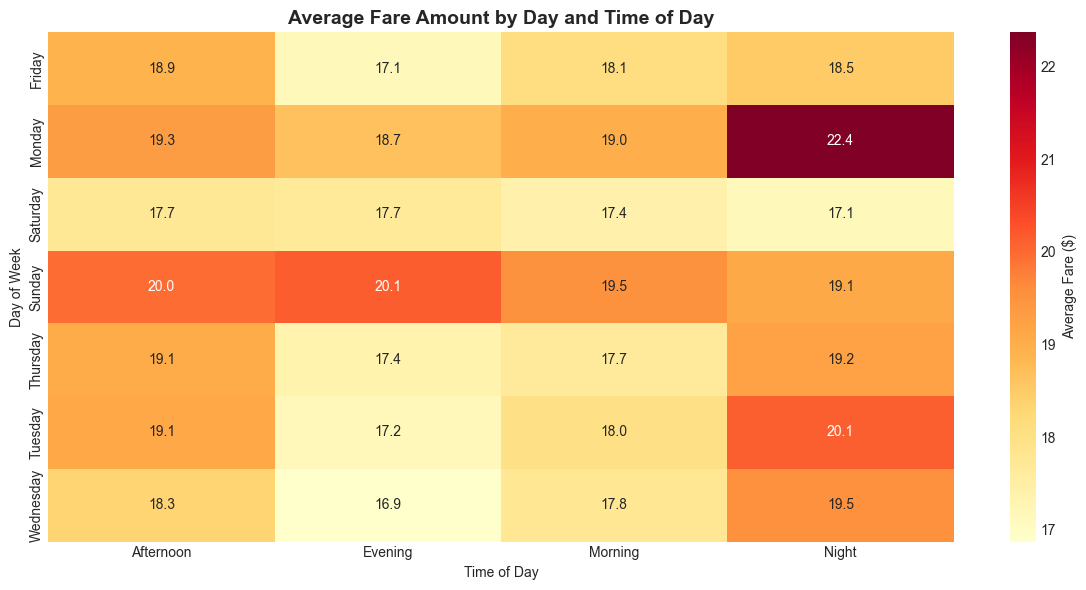

In [6]:
# Create a pivot table: Average fare by day of week and time of day
pivot_fare = df_ts.pivot_table(
    values='fare_amount',
    index='day_name',
    columns='time_of_day',
    aggfunc='mean'
)

display(Markdown("### 📊 Average Fare by Day of Week and Time of Day"))
display(pivot_fare.round(2))

# Visualize the pivot table
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_fare, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Average Fare ($)'})
plt.title('Average Fare Amount by Day and Time of Day', fontsize=14, fontweight='bold')
plt.xlabel('Time of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

### Step 6: Reshape Data - Melt Example

In [7]:
# Example: Convert wide format to long format
# Let's create a summary by hour with multiple metrics

hourly_summary = df_ts.groupby('hour').agg({
    'fare_amount': 'mean',
    'trip_distance': 'mean',
    'trip_duration': 'mean',
    'passenger_count': 'mean'
}).reset_index()

display(Markdown("### 📋 Hourly Summary (Wide Format)"))
display(hourly_summary.head().round(2))

# Melt to long format
hourly_long = hourly_summary.melt(
    id_vars='hour',
    value_vars=['fare_amount', 'trip_distance', 'trip_duration', 'passenger_count'],
    var_name='metric',
    value_name='value'
)

display(Markdown("### 📋 Hourly Summary (Long Format)"))
display(hourly_long.head(10).round(2))

### 📋 Hourly Summary (Wide Format)

,hour,fare_amount,trip_distance,trip_duration,passenger_count
0,0,19.75,4.02,13.44,1.44
1,1,17.79,3.49,12.46,1.46
2,2,16.71,3.22,11.85,1.46
3,3,17.67,3.50,11.91,1.44
4,4,22.20,4.68,13.23,1.41


### 📋 Hourly Summary (Long Format)

,hour,metric,value
0,0,fare_amount,19.75
1,1,fare_amount,17.79
2,2,fare_amount,16.71
3,3,fare_amount,17.67
4,4,fare_amount,22.20
5,5,fare_amount,26.35
6,6,fare_amount,22.03
7,7,fare_amount,18.86
8,8,fare_amount,17.38
9,9,fare_amount,17.57


---

## Phase 5: Feature Engineering & Aggregation

**What we're about to do:** We'll create new features from existing data. This is where domain knowledge becomes code - we create variables that capture meaningful patterns.

**Why create new features?** The raw data has trip_distance and trip_duration, but combining them gives us speed - a feature that might be more predictive than either alone. Feature engineering is about creating variables that capture meaningful relationships.

**Features we'll create:**

- **Speed (mph):** Traffic patterns affect fares
- **Fare per mile:** Pricing efficiency
- **Tip percentage:** Customer satisfaction proxy
- **Distance categories:** Short/medium/long trips

**What you'll learn:**

- How to derive new features from existing columns
- How GroupBy aggregations reveal patterns
- How rolling windows smooth trends
- How to think about what features might be predictive

### Learning Objectives

- Create derived features
- Perform groupby aggregations
- Calculate rolling window statistics
- Create time-based features
- Aggregate by multiple dimensions

### Step 1: Create Derived Features

In [8]:
# Feature engineering constants
MINUTES_PER_HOUR = 60
MAX_REASONABLE_SPEED_MPH = 60  # Highway speed limit in NYC area

# Speed (miles per hour) - derived from distance and duration
duration_hours = df_ts['trip_duration'] / MINUTES_PER_HOUR
df_ts['speed_mph'] = df_ts['trip_distance'] / duration_hours
df_ts['speed_mph'] = df_ts['speed_mph'].replace([np.inf, -np.inf], np.nan)  # Handle division by zero
df_ts['speed_mph'] = df_ts['speed_mph'].clip(upper=MAX_REASONABLE_SPEED_MPH)

# Fare per mile
df_ts['fare_per_mile'] = df_ts['fare_amount'] / df_ts['trip_distance']
df_ts['fare_per_mile'] = df_ts['fare_per_mile'].replace([np.inf, -np.inf], np.nan)

# Tip percentage
df_ts['tip_percentage'] = (df_ts['tip_amount'] / df_ts['fare_amount']) * 100
df_ts['tip_percentage'] = df_ts['tip_percentage'].fillna(0)  # No tip = 0%

# Distance category thresholds (miles) - based on typical NYC trip patterns
SHORT_TRIP_MAX = 1.0   # Neighborhood trips, often walkable
MEDIUM_TRIP_MAX = 3.0  # Cross-neighborhood, typical taxi trip
LONG_TRIP_MAX = 10.0   # Cross-borough, airport trips

def categorize_distance(dist):
    """
    Categorize trip distance based on NYC geography.

    - Short (<1 mi): Within neighborhood
    - Medium (1-3 mi): Cross-neighborhood, typical taxi trip
    - Long (3-10 mi): Cross-borough, airport trips
    - Very Long (>10 mi): Outer borough/suburbs
    """
    if dist < SHORT_TRIP_MAX:
        return 'Short'
    elif dist < MEDIUM_TRIP_MAX:
        return 'Medium'
    elif dist < LONG_TRIP_MAX:
        return 'Long'
    else:
        return 'Very Long'

df_ts['distance_category'] = df_ts['trip_distance'].apply(categorize_distance)

display(Markdown("### ✨ Derived Features Created"))
display(df_ts[['speed_mph', 'fare_per_mile', 'tip_percentage', 'distance_category']].head(10).round(2))

### ✨ Derived Features Created

,speed_mph,fare_per_mile,tip_percentage,distance_category
pickup_datetime,,,,
2023-01-01 00:00:05,3.00,16.59,0.00,Medium
2023-01-01 00:00:06,18.11,5.47,0.00,Medium
2023-01-01 00:00:08,16.51,5.26,0.00,Long
2023-01-01 00:00:09,15.18,5.21,37.58,Long
2023-01-01 00:00:13,42.55,3.85,72.46,Long
2023-01-01 00:00:18,13.60,5.43,42.98,Medium
2023-01-01 00:00:35,42.68,3.77,0.00,Very Long
2023-01-01 00:00:47,15.20,6.84,76.92,Short
2023-01-01 00:00:52,16.52,4.60,0.00,Long


### Step 2: GroupBy Aggregations

**What is GroupBy?**
GroupBy splits data into groups, applies a function to each group, and combines the results. It's one of pandas' most powerful features for data analysis.

**Why use GroupBy?**

- **Summarize:** Calculate statistics for each group (e.g., average fare by day of week)
- **Compare:** See how metrics differ across groups
- **Aggregate:** Reduce data size while preserving important patterns
- **Explore:** Discover relationships between categorical and numeric variables

**Common GroupBy operations:**

- **Single column:** `groupby('day_of_week')` - group by one variable
- **Multiple columns:** `groupby(['day_of_week', 'time_of_day'])` - group by multiple variables
- **Multiple functions:** `agg({'fare': 'mean', 'distance': 'sum'})` - different functions for different columns

**🔬 Try This First: Experiment with Simple GroupBy**

Before we do complex aggregations, let's understand GroupBy with a simple example:

In [9]:
# Simple experiment: Group by day of week and see what we get
simple_groupby = df_ts.groupby('day_name')['fare_amount'].mean()
print("Average fare by day:")
print(simple_groupby)
print()

# Try different aggregations on the same grouping
experiments = df_ts.groupby('day_name')['fare_amount'].agg(['mean', 'median', 'std', 'count'])
print("Multiple statistics by day:")
print(experiments)
print()

# Question: What patterns do you notice?
# - Which day has the highest average fare? Why might that be?
# - How does mean compare to median? What does that tell you about the distribution?

Average fare by day:
day_name
Friday       18.176981
Monday       19.538322
Saturday     17.485352
Sunday       19.672692
Thursday     18.287405
Tuesday      18.436054
Wednesday    17.972460
Name: fare_amount, dtype: float64

Multiple statistics by day:
                mean  median        std   count
day_name                                       
Friday     18.176981    12.8  16.242875  408468
Monday     19.538322    12.8  18.580645  379694
Saturday   17.485352    12.8  15.171394  415861
Sunday     19.672692    12.8  18.241606  407572
Thursday   18.287405    12.8  16.165430  414402
Tuesday    18.436054    12.8  16.622620  461668
Wednesday  17.972460    12.8  15.988143  391420



**Learning goal:** GroupBy is about asking "what's the average/median/count of X for each value of Y?" Experimenting helps you understand the power of this operation.

Now let's do more complex aggregations:

In [10]:
# Aggregate by day of week
daily_stats = df_ts.groupby('day_name').agg({
    'fare_amount': ['mean', 'median', 'std', 'count'],
    'trip_distance': ['mean', 'median'],
    'trip_duration': ['mean', 'median'],
    'passenger_count': 'mean'
}).round(2)

# Flatten multi-level column names for cleaner display
daily_stats.columns = ['_'.join(col).strip() for col in daily_stats.columns.values]
display(Markdown("### 📅 Statistics by Day of Week"))
display(daily_stats)

# Aggregate by multiple dimensions: day of week and time of day
multi_agg = df_ts.groupby(['day_name', 'time_of_day']).agg({
    'fare_amount': 'mean',
    'trip_distance': 'count'  # Count of trips
}).rename(columns={'fare_amount': 'avg_fare', 'trip_distance': 'trip_count'}).round(2)

display(Markdown("### 📊 Average Fare by Day and Time"))
display(multi_agg.head(15))

### 📅 Statistics by Day of Week

,fare_amount_mean,fare_amount_median,fare_amount_std,fare_amount_count,trip_distance_mean,trip_distance_median,trip_duration_mean,trip_duration_median,passenger_count_mean
day_name,,,,,,,,,
Friday,18.18,12.8,16.24,408468,3.29,1.76,14.83,11.72,1.39
Monday,19.54,12.8,18.58,379694,3.82,1.84,14.30,11.02,1.37
Saturday,17.49,12.8,15.17,415861,3.15,1.81,13.75,11.33,1.48
Sunday,19.67,12.8,18.24,407572,3.88,2.00,13.82,11.07,1.47
Thursday,18.29,12.8,16.17,414402,3.25,1.74,15.24,12.12,1.34
Tuesday,18.44,12.8,16.62,461668,3.34,1.75,14.84,11.72,1.33
Wednesday,17.97,12.8,15.99,391420,3.22,1.73,14.62,11.73,1.33


### 📊 Average Fare by Day and Time

avg_fare  trip_count
day_name time_of_day                      
Friday   Afternoon       18.93      119551
         Evening         17.14      106874
         Morning         18.08       90411
         Night           18.50       91632
Monday   Afternoon       19.33      126035
         Evening         18.67       99544
         Morning         18.99       95705
         Night           22.37       58410
Saturday Afternoon       17.75      121900
         Evening         17.68      100481
         Morning         17.39       65013
         Night           17.13      128467
Sunday   Afternoon       19.98      127496
         Evening         20.15       86500
         Morning         19.53       68016

### Step 3: Rolling Window Calculations

**What are rolling windows?**
Rolling windows calculate statistics over a sliding window of time periods. For example, a 7-day rolling mean calculates the average of the current day and the previous 6 days.

**Why use rolling windows?**

- **Smooth trends:** Remove daily noise to see underlying patterns
- **Moving averages:** Common in time series analysis
- **Trend detection:** Identify increasing/decreasing trends
- **Anomaly detection:** Compare current values to rolling statistics

**Common rolling window operations:**

- **Rolling mean:** Average over window (smooths data)
- **Rolling median:** Median over window (robust to outliers)
- **Rolling std:** Standard deviation over window (measures volatility)
- **Rolling min/max:** Min/max over window (identifies extremes)

**Window size considerations:**

- **Small windows (3-7 days):** Capture short-term patterns, more responsive to changes
- **Large windows (30+ days):** Capture long-term trends, smoother but less responsive

In [11]:
# Resample to hourly for rolling calculations
hourly_trips = df_ts.resample('h').agg({
    'fare_amount': ['mean', 'count'],
    'trip_distance': 'mean',
    'total_amount': 'sum'
})
hourly_trips.columns = ['fare_amount', 'trip_count', 'trip_distance', 'total_amount']
hourly_trips = hourly_trips[['fare_amount', 'trip_distance', 'total_amount', 'trip_count']]

# Rolling window parameters (in hours, since we're using hourly data)
SHORT_WINDOW_DAYS = 7   # Weekly pattern detection
LONG_WINDOW_DAYS = 30   # Monthly trend detection
HOURS_PER_DAY = 24

SHORT_WINDOW_HOURS = SHORT_WINDOW_DAYS * HOURS_PER_DAY  # 168 hours
LONG_WINDOW_HOURS = LONG_WINDOW_DAYS * HOURS_PER_DAY    # 720 hours

# Calculate rolling averages
hourly_trips['fare_7d_avg'] = hourly_trips['fare_amount'].rolling(
    window=SHORT_WINDOW_HOURS, min_periods=1).mean()
hourly_trips['fare_30d_avg'] = hourly_trips['fare_amount'].rolling(
    window=LONG_WINDOW_HOURS, min_periods=1).mean()

# Exponentially weighted moving average (gives more weight to recent data)
hourly_trips['fare_ewm'] = hourly_trips['fare_amount'].ewm(
    span=SHORT_WINDOW_HOURS, adjust=False).mean()

display(Markdown("### 📈 Rolling Window Calculations"))
display(hourly_trips[['fare_amount', 'fare_7d_avg', 'fare_30d_avg', 'fare_ewm']].head(20).round(2))

### 📈 Rolling Window Calculations

,fare_amount,fare_7d_avg,fare_30d_avg,fare_ewm
pickup_datetime,,,,
2023-01-01 00:00:00,18.61,18.61,18.61,18.61
2023-01-01 01:00:00,17.98,18.30,18.30,18.60
2023-01-01 02:00:00,17.34,17.98,17.98,18.59
2023-01-01 03:00:00,17.86,17.95,17.95,18.58
2023-01-01 04:00:00,19.37,18.23,18.23,18.59
2023-01-01 05:00:00,24.37,19.26,19.26,18.66
2023-01-01 06:00:00,28.61,20.59,20.59,18.77
2023-01-01 07:00:00,28.14,21.54,21.54,18.88
2023-01-01 08:00:00,26.96,22.14,22.14,18.98


Now let's visualize how rolling averages smooth the raw data:

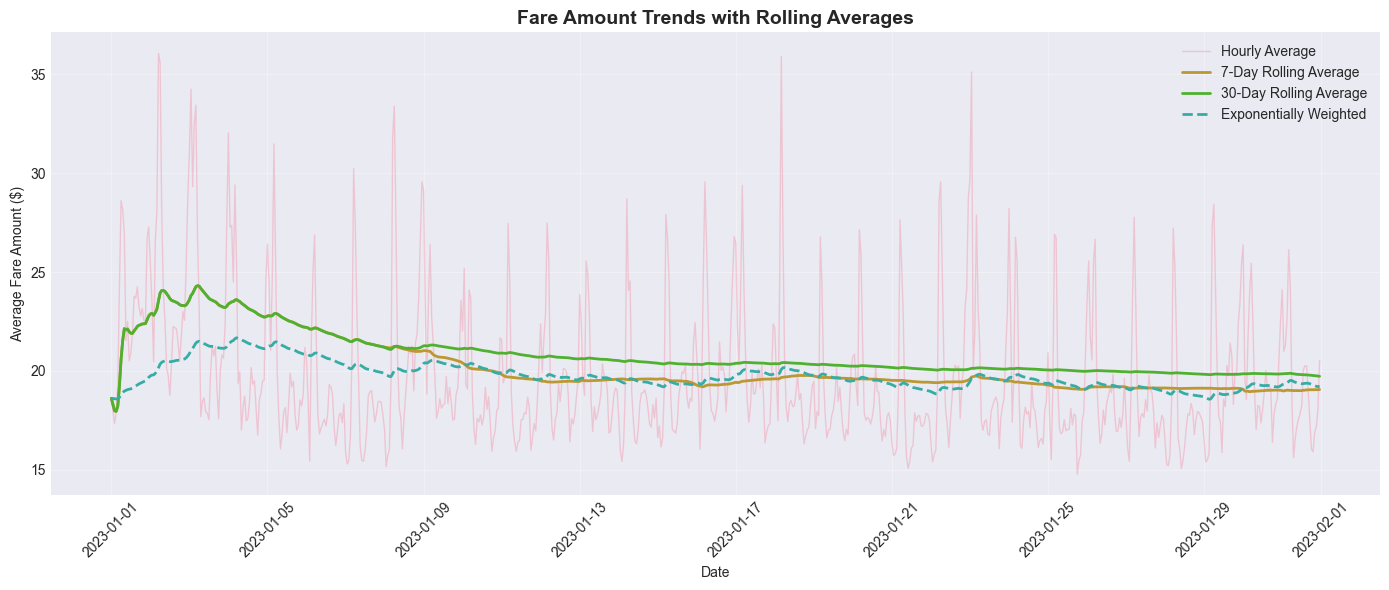

In [12]:
# Visualize rolling averages
plt.figure(figsize=(14, 6))
plt.plot(hourly_trips.index, hourly_trips['fare_amount'], alpha=0.3, label='Hourly Average', linewidth=1)
plt.plot(hourly_trips.index, hourly_trips['fare_7d_avg'], label='7-Day Rolling Average', linewidth=2)
plt.plot(hourly_trips.index, hourly_trips['fare_30d_avg'], label='30-Day Rolling Average', linewidth=2)
plt.plot(hourly_trips.index, hourly_trips['fare_ewm'], label='Exponentially Weighted', linewidth=2, linestyle='--')
plt.title('Fare Amount Trends with Rolling Averages', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Average Fare Amount ($)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 3b: Time-Series Specific Operations

**Important distinction:** The NYC Taxi data is **event-based** (discrete trips), but many real-world datasets are **continuous time-series** (sensor readings, weather data, stock prices). If your data is time-series, you'll need additional techniques.

**When you need time-series techniques:**

- Sensor data (temperature, pressure, flow)
- Financial data (stock prices, trading volume)
- IoT/telemetry data (device metrics)
- Continuous monitoring data

**Key difference:**

- **Event-based (taxi trips):** Each row is a discrete event with a timestamp
- **Time-series (sensors):** Continuous measurements at (possibly irregular) intervals

#### Handling Irregular Sampling

Time-series data often has irregular sampling - sensors may report at inconsistent intervals due to connectivity issues, power saving, or variable conditions.

In [13]:
# Example: Resample irregular sensor data to regular intervals

# Our taxi data is already fairly regular (trips happen continuously)
# But let's demonstrate resampling for time-series data

# Resample to hourly intervals (useful for irregular data)
hourly_regular = df_ts.resample('h').agg({
    'fare_amount': 'mean',      # Average fare per hour
    'trip_distance': 'sum',     # Total distance per hour
    'passenger_count': 'sum'    # Total passengers per hour
})

display(Markdown("### 📊 Resampled to Hourly Intervals"))
display(hourly_regular.head(10).round(2))

# Common resampling frequencies:
# 'h' = hourly, 'D' = daily, 'W' = weekly, 'ME' = month end
# 'min' = minute, '15min' = 15 minutes, '6h' = 6 hours

### 📊 Resampled to Hourly Intervals

,fare_amount,trip_distance,passenger_count
pickup_datetime,,,
2023-01-01 00:00:00,18.61,16017.80,7730.0
2023-01-01 01:00:00,17.98,15982.08,8026.0
2023-01-01 02:00:00,17.34,14056.80,6917.0
2023-01-01 03:00:00,17.86,11233.75,4984.0
2023-01-01 04:00:00,19.37,8168.29,3216.0
2023-01-01 05:00:00,24.37,4936.86,1384.0
2023-01-01 06:00:00,28.61,4969.40,1134.0
2023-01-01 07:00:00,28.14,5828.60,1342.0
2023-01-01 08:00:00,26.96,6306.99,1516.0


**Why resample?**

- **Regularize irregular data:** Sensors may report every 5 min, 7 min, 12 min → resample to consistent 15 min
- **Reduce noise:** High-frequency data can be noisy → aggregate to lower frequency
- **Match granularity:** Align different data sources to same time intervals

#### Creating Lag Features for Time-Series Prediction

In time-series data, **past values often predict future values**. Lag features shift data backward in time to capture temporal dependencies.

In [14]:
# Create lag features for trip volume prediction
# These are useful when predicting future volume based on past patterns

# Calculate hourly trip counts first
hourly_counts = df_ts.resample('h').size().to_frame(name='trip_count')

# Create lag features (shift data backward)
hourly_counts['trips_lag_1h'] = hourly_counts['trip_count'].shift(1)      # 1 hour ago
hourly_counts['trips_lag_6h'] = hourly_counts['trip_count'].shift(6)      # 6 hours ago
hourly_counts['trips_lag_24h'] = hourly_counts['trip_count'].shift(24)    # Same hour yesterday
hourly_counts['trips_lag_168h'] = hourly_counts['trip_count'].shift(168)  # Same hour last week

display(Markdown("### 🕐 Lag Features (Past Values as Predictors)"))

# Show random set of rows in 2023
display(hourly_counts[hourly_counts.index.year == 2023].sample(25))

### 🕐 Lag Features (Past Values as Predictors)

,trip_count,trips_lag_1h,trips_lag_6h,trips_lag_24h,trips_lag_168h
pickup_datetime,,,,,
2023-01-12 22:00:00,5084,5784.0,6284.0,5021.0,4385.0
2023-01-19 19:00:00,7175,8025.0,5822.0,6851.0,6536.0
2023-01-12 16:00:00,6284,6450.0,4927.0,6432.0,6035.0
2023-01-27 05:00:00,535,413.0,4658.0,501.0,575.0
2023-01-01 13:00:00,3721,3494.0,915.0,NaN,NaN
2023-01-20 00:00:00,2449,3874.0,8025.0,1703.0,2767.0
2023-01-06 10:00:00,4536,4184.0,269.0,4724.0,NaN
2023-01-28 12:00:00,5654,4817.0,722.0,5354.0,5859.0
2023-01-12 19:00:00,6536,8759.0,5732.0,6708.0,5980.0


**When to use lag features:**

- Predicting future temperature based on recent temperatures
- Forecasting demand based on historical patterns
- Predicting sensor failures based on previous readings

**⚠️ Important:** Lag features create NaN values at the beginning (no past data exists). Handle with `.dropna()` or forward-fill if appropriate.

#### Time-Series Decomposition (Advanced)

For continuous time-series, you can separate the signal into components: **Trend + Seasonal + Residual**

In [15]:
# Demonstrate time-series decomposition with daily trip counts
daily_counts = df_ts.resample('D').size()

from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series (requires at least 2 full cycles)
# For taxi data with weekly patterns, we need at least 14 days
decomposition = seasonal_decompose(
    daily_counts,
    model='additive',    # Additive: components add up (Trend + Seasonal + Residual)
    period=7             # Weekly seasonality (7 days)
)

Now let's visualize the decomposition components:

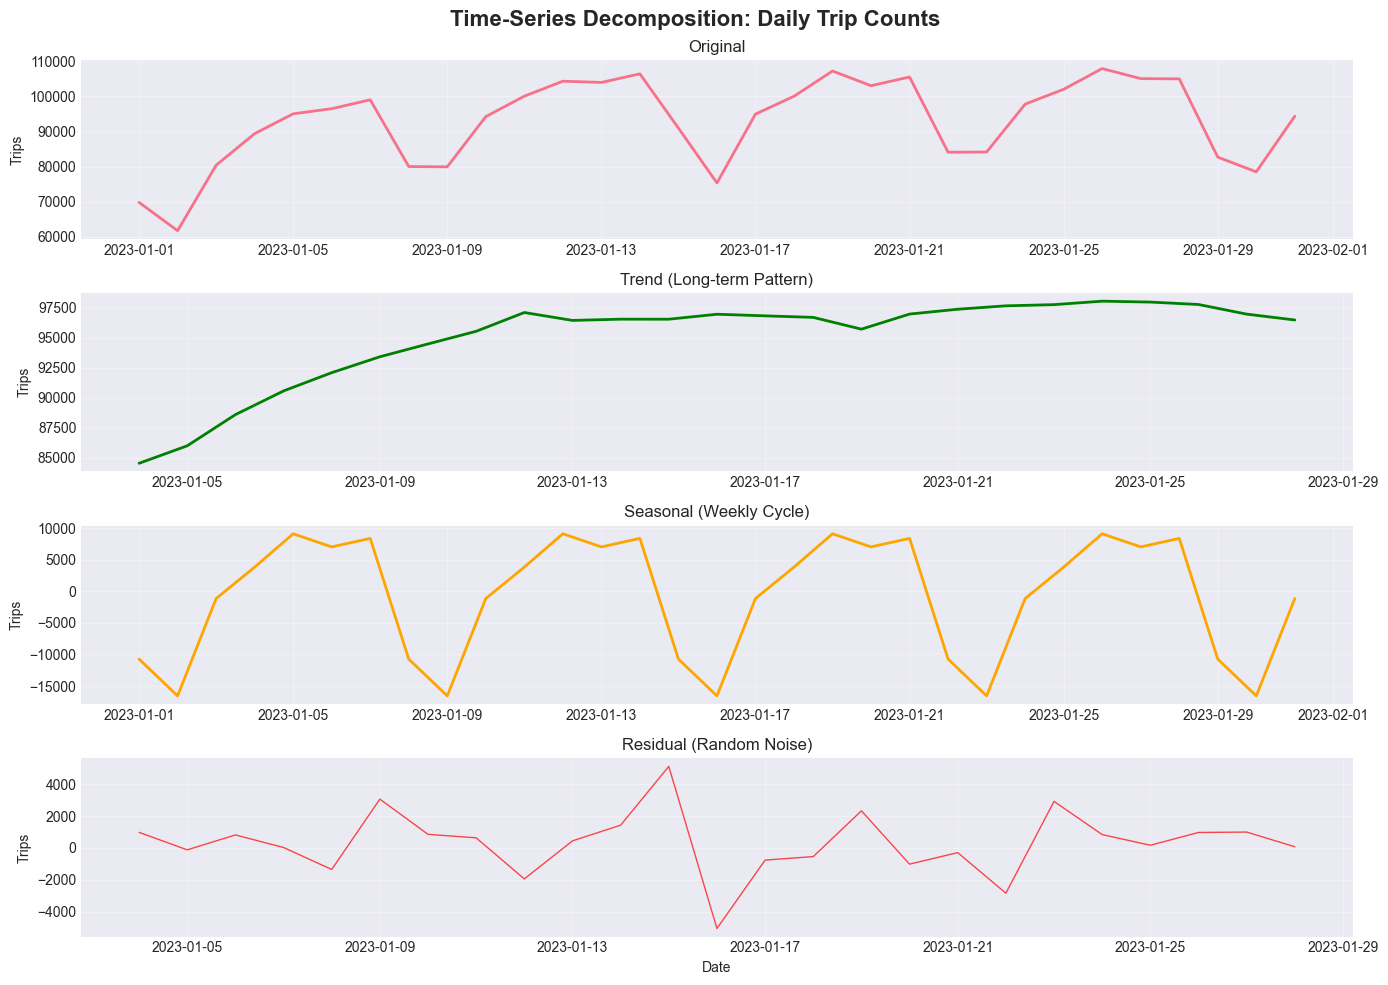


### 📈 Understanding Decomposition Components

- **Trend:** Long-term increase/decrease (e.g., growing demand over months)
- **Seasonal:** Repeating patterns (e.g., weekday vs weekend, or hourly cycles)
- **Residual:** Random noise after removing trend and seasonality

**Why decompose?**
- Understand what drives patterns (is variation due to trend, seasonality, or noise?)
- Remove seasonality to see underlying trends
- Forecast by modeling each component separately


In [16]:
# Visualize decomposition components
fig, axes = plt.subplots(4, 1, figsize=(14, 10))
fig.suptitle('Time-Series Decomposition: Daily Trip Counts', fontsize=16, fontweight='bold')

# Original data
axes[0].plot(daily_counts.index, daily_counts.values, linewidth=2)
axes[0].set_ylabel('Trips')
axes[0].set_title('Original')
axes[0].grid(True, alpha=0.3)

# Trend component
axes[1].plot(decomposition.trend.index, decomposition.trend.values, linewidth=2, color='green')
axes[1].set_ylabel('Trips')
axes[1].set_title('Trend (Long-term Pattern)')
axes[1].grid(True, alpha=0.3)

# Seasonal component
axes[2].plot(decomposition.seasonal.index, decomposition.seasonal.values, linewidth=2, color='orange')
axes[2].set_ylabel('Trips')
axes[2].set_title('Seasonal (Weekly Cycle)')
axes[2].grid(True, alpha=0.3)

# Residual (random noise)
axes[3].plot(decomposition.resid.index, decomposition.resid.values, linewidth=1, color='red', alpha=0.7)
axes[3].set_ylabel('Trips')
axes[3].set_title('Residual (Random Noise)')
axes[3].set_xlabel('Date')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

display(Markdown("""
### 📈 Understanding Decomposition Components

- **Trend:** Long-term increase/decrease (e.g., growing demand over months)
- **Seasonal:** Repeating patterns (e.g., weekday vs weekend, or hourly cycles)
- **Residual:** Random noise after removing trend and seasonality

**Why decompose?**
- Understand what drives patterns (is variation due to trend, seasonality, or noise?)
- Remove seasonality to see underlying trends
- Forecast by modeling each component separately
"""))

#### Autocorrelation (Brief Introduction)

**Autocorrelation** measures how a time series correlates with itself at different time lags. High autocorrelation at lag 24 (for hourly data) means "values 24 hours apart are similar."

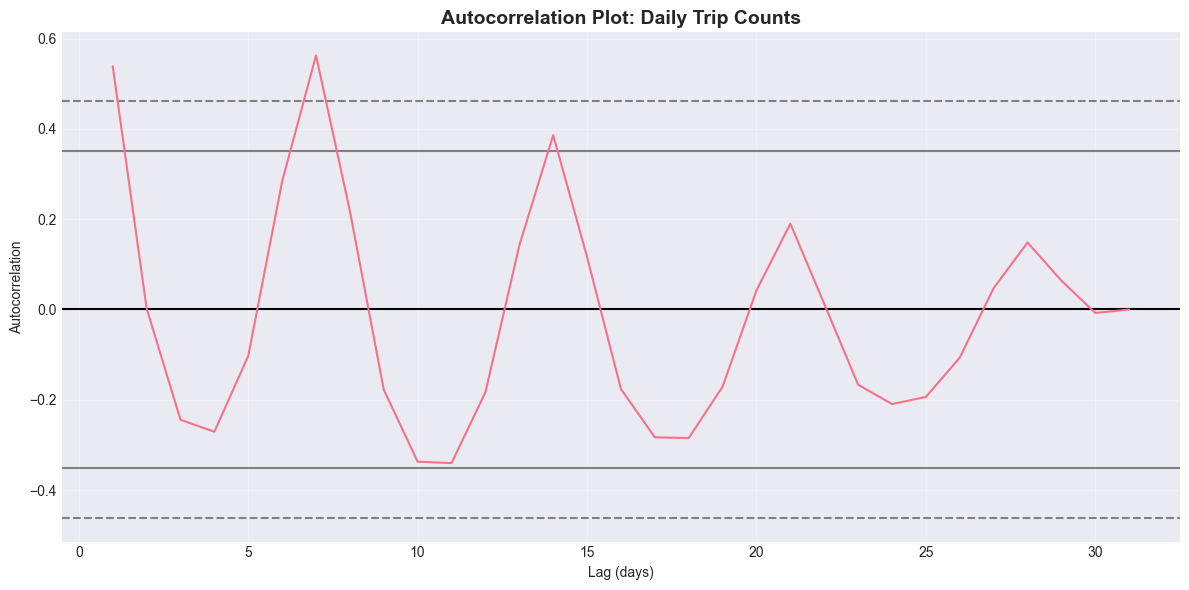


### 🔗 Interpreting Autocorrelation

- **High correlation at lag 7:** Strong weekly pattern (same day of week)
- **Gradual decay:** Persistent trends
- **Quick drop to zero:** Data is mostly random

**Why it matters:**
- Helps identify seasonality periods
- Tells us if lag features will be useful
- Informs model choice (some models assume low autocorrelation)


In [17]:
# Quick autocorrelation check (visual)
# This helps identify temporal patterns

from pandas.plotting import autocorrelation_plot

fig, ax = plt.subplots(figsize=(12, 6))
autocorrelation_plot(daily_counts, ax=ax)
ax.set_title('Autocorrelation Plot: Daily Trip Counts', fontsize=14, fontweight='bold')
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Autocorrelation')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

display(Markdown("""
### 🔗 Interpreting Autocorrelation

- **High correlation at lag 7:** Strong weekly pattern (same day of week)
- **Gradual decay:** Persistent trends
- **Quick drop to zero:** Data is mostly random

**Why it matters:**
- Helps identify seasonality periods
- Tells us if lag features will be useful
- Informs model choice (some models assume low autocorrelation)
"""))

**For your final assignment:** If you're working with continuous sensor data (like Chicago Beach Weather), use these time-series techniques to:

1. Resample irregular readings to regular intervals
2. Create lag features (e.g., temperature 1 hour ago, 24 hours ago)
3. Identify trends and seasonality with decomposition
4. Check autocorrelation to understand temporal dependencies

---

### Step 4: Time-Based Aggregations

### ⏰ Hourly Patterns (aggregated across all days)

,fare_amount,trip_count,trip_distance,total_amount
hour,,,,
0,19.75,79358,4.02,1888402.23
1,17.79,55423,3.49,1194547.92
2,16.71,38631,3.22,780810.54
3,17.67,24971,3.50,530251.21
4,22.20,15776,4.68,412707.22
5,26.35,16096,5.96,494681.27
6,22.03,39880,4.76,1036843.62
7,18.86,79440,3.67,1795334.51
8,17.38,107717,3.07,2263876.79


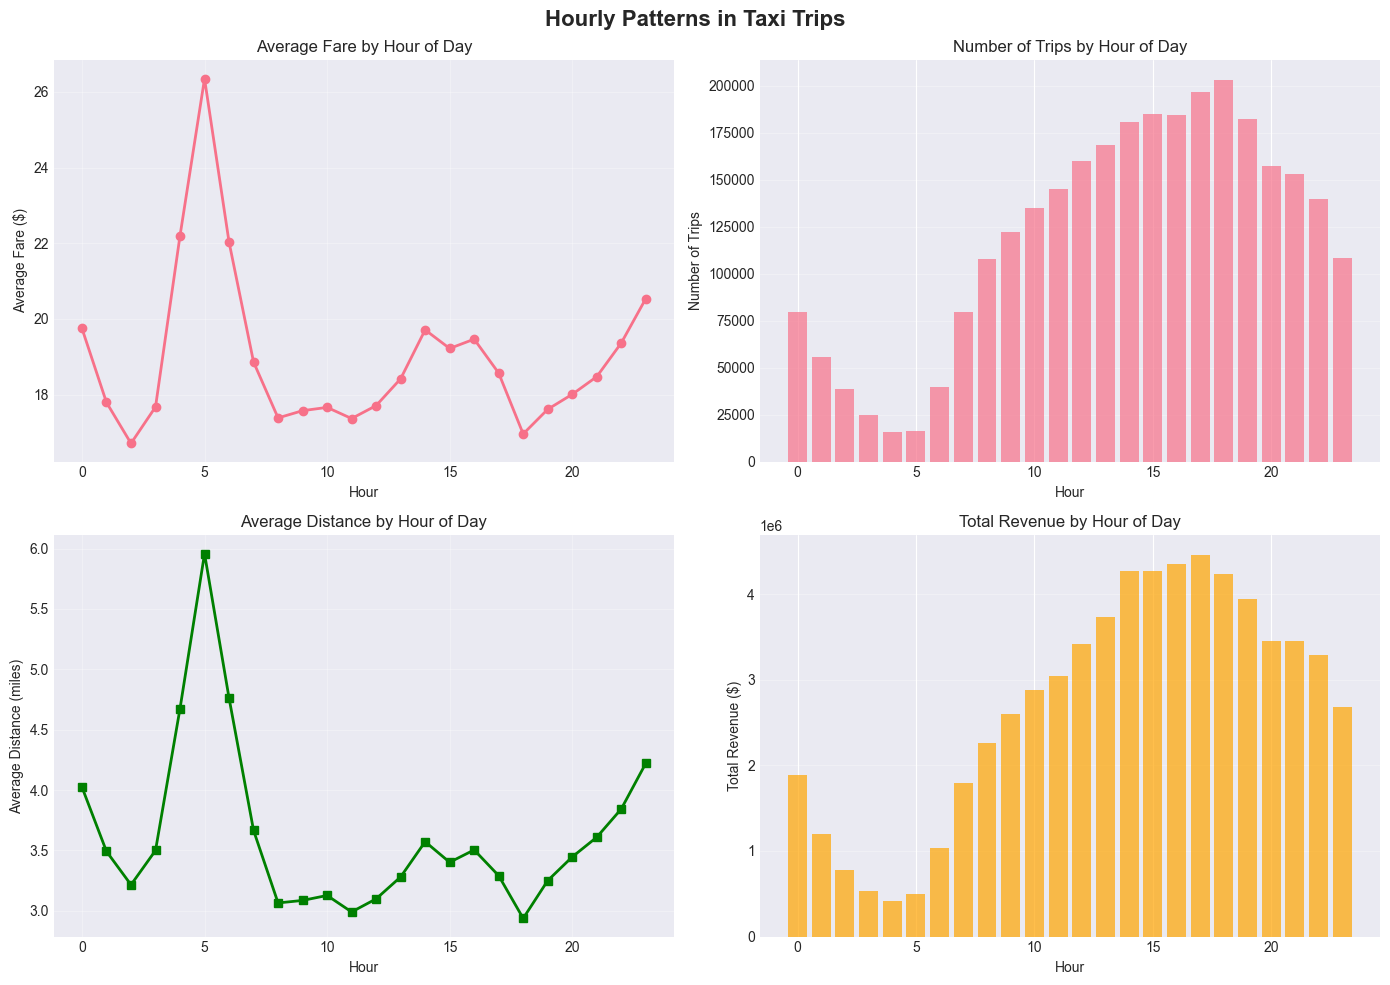

In [18]:
# Aggregate by hour of day (across all days)
hourly_pattern = df_ts.groupby('hour').agg({
    'fare_amount': ['mean', 'count'],
    'trip_distance': 'mean',
    'total_amount': 'sum'
})
hourly_pattern.columns = ['fare_amount', 'trip_count', 'trip_distance', 'total_amount']
hourly_pattern = hourly_pattern[['fare_amount', 'trip_count', 'trip_distance', 'total_amount']]

display(Markdown("### ⏰ Hourly Patterns (aggregated across all days)"))
display(hourly_pattern.head(10).round(2))

# Visualize hourly patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Hourly Patterns in Taxi Trips', fontsize=16, fontweight='bold')

# Average fare by hour
axes[0, 0].plot(hourly_pattern.index, hourly_pattern['fare_amount'], marker='o', linewidth=2)
axes[0, 0].set_title('Average Fare by Hour of Day')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Average Fare ($)')
axes[0, 0].grid(True, alpha=0.3)

# Trip count by hour
axes[0, 1].bar(hourly_pattern.index, hourly_pattern['trip_count'], alpha=0.7)
axes[0, 1].set_title('Number of Trips by Hour of Day')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Number of Trips')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Average distance by hour
axes[1, 0].plot(hourly_pattern.index, hourly_pattern['trip_distance'], marker='s', color='green', linewidth=2)
axes[1, 0].set_title('Average Distance by Hour of Day')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Average Distance (miles)')
axes[1, 0].grid(True, alpha=0.3)

# Total revenue by hour
axes[1, 1].bar(hourly_pattern.index, hourly_pattern['total_amount'], alpha=0.7, color='orange')
axes[1, 1].set_title('Total Revenue by Hour of Day')
axes[1, 1].set_xlabel('Hour')
axes[1, 1].set_ylabel('Total Revenue ($)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Step 5: Cross-Tabulation

In [19]:
# Cross-tabulation: Day of week vs Time of day
crosstab = pd.crosstab(
    df_ts['day_name'],
    df_ts['time_of_day'],
    margins=True
)

display(Markdown("### 📊 Trip Count: Day of Week × Time of Day"))
display(crosstab)

# Cross-tabulation with aggregation
crosstab_fare = pd.crosstab(
    df_ts['day_name'],
    df_ts['time_of_day'],
    values=df_ts['fare_amount'],
    aggfunc='mean',
    margins=True
).round(2)

display(Markdown("### 💵 Average Fare: Day of Week × Time of Day"))
display(crosstab_fare)

### 📊 Trip Count: Day of Week × Time of Day

time_of_day,Afternoon,Evening,Morning,Night,All
day_name,,,,,
Friday,119551,106874,90411,91632,408468
Monday,126035,99544,95705,58410,379694
Saturday,121900,100481,65013,128467,415861
Sunday,127496,86500,68016,125560,407572
Thursday,122951,113178,102663,75610,414402
Tuesday,141336,123492,125551,71289,461668
Wednesday,119235,109656,98347,64182,391420
All,878504,739725,645706,615150,2879085


### 💵 Average Fare: Day of Week × Time of Day

time_of_day,Afternoon,Evening,Morning,Night,All
day_name,,,,,
Friday,18.93,17.14,18.08,18.50,18.18
Monday,19.33,18.67,18.99,22.37,19.54
Saturday,17.75,17.68,17.39,17.13,17.49
Sunday,19.98,20.15,19.53,19.10,19.67
Thursday,19.08,17.36,17.66,19.23,18.29
Tuesday,19.11,17.17,17.97,20.12,18.44
Wednesday,18.31,16.87,17.76,19.54,17.97
All,18.94,17.77,18.16,19.09,18.50


### 💡 Alternative Approach: GroupBy vs. Pivot vs. Reshape

We used GroupBy, but pandas offers multiple ways to aggregate:

| Method | When to Use | Example |
|--------|-------------|---------|
| **GroupBy** | Most flexible, default choice | `df.groupby('day')['fare'].mean()` |
| **Pivot Table** | 2D summary tables | `df.pivot_table(values='fare', index='day', columns='time')` |
| **Crosstab** | Frequency/aggregate cross-tabs | `pd.crosstab(df['day'], df['time'], values=df['fare'], aggfunc='mean')` |
| **stack/unstack** | Reshape long ↔ wide | `grouped.unstack(level='time')` |

**🔬 Try This:** Recreate the same summary using different methods. Which feels most natural for your use case?

**Answer:** For most cases, **GroupBy is the most flexible and readable**. Use **Pivot Table** when you want 2D summary tables (rows × columns), and **Crosstab** for frequency counts with optional aggregations. **Example:** `df.groupby(['day', 'time'])['fare'].mean()` gives same result as `df.pivot_table(values='fare', index='day', columns='time')`, but GroupBy syntax feels more explicit about what you're doing.

### 🐛 Debugging Tips: Wrangling Issues

**Problem: Merge creates unexpected NaN values**

- Check join keys: `df1['key'].nunique()` vs `df2['key'].nunique()`
- Check for mismatches: `df1[~df1['key'].isin(df2['key'])]`
- Verify join type: Using `how='left'` vs `how='inner'`?

**Problem: GroupBy returns unexpected results**

- Check for NaN in groupby column: `df['group_col'].isna().sum()`
- Verify grouping: `df.groupby('group_col').size()` (shows all groups)

**Problem: Can't set datetime index**

- Parse datetime first: `df['datetime'] = pd.to_datetime(df['datetime'])`
- Check for invalid dates: `df[pd.to_datetime(df['datetime'], errors='coerce').isna()]`

### ⚠️ Critical Warning: Feature Leakage

**What is feature leakage?** Using information from the future or from the target variable itself to make predictions. This creates artificially high performance that doesn't work in real-world deployment.

**Common mistakes that cause leakage:**

#### 1. Using Target Variable in Features

```
# ❌ WRONG: Creating features from the target
df['fare_per_mile'] = df['fare_amount'] / df['trip_distance']  # OK - uses predictors
df['tip_percentage'] = df['tip_amount'] / df['fare_amount']     # DANGER if predicting fare_amount!

# ✅ CORRECT: Only use predictor variables in features
# If predicting fare_amount, don't use tip_amount (which depends on fare)
```

#### 2. Rolling Windows of Target Variable

```
# ❌ WRONG: Rolling average of what you're trying to predict
df['fare_7d_avg'] = df['fare_amount'].rolling(7).mean()  # Uses future fares!

# ✅ CORRECT: Rolling averages of predictor variables
df['distance_7d_avg'] = df['trip_distance'].rolling(7).mean()  # Uses past trips
```

#### 3. Aggregations That Include Future Data

```
# ❌ WRONG: Group statistics that include the row itself
df['zone_avg_fare'] = df.groupby('zone')['fare_amount'].transform('mean')  # Includes itself!

# ✅ CORRECT: Use .shift() to only use past data
df['zone_avg_fare_lag'] = df.groupby('zone')['fare_amount'].transform('mean').shift(1)
```

**How to detect feature leakage:**

1. **Check correlations:** Features with r > 0.95 with target are suspicious
2. **Think temporally:** "Would I have this information at prediction time?"
3. **Test on future data:** If performance drops dramatically, you likely have leakage

**Example of leakage in time-series:**

```
# Creating lag features (CORRECT)
df['temp_lag_1h'] = df['temperature'].shift(1)  # Use past to predict future ✅

# But be careful with aggregations
df['daily_avg_temp'] = df.groupby(df.index.date)['temperature'].transform('mean')  # ❌
# This includes the current hour's temperature in the daily average!
```

**Rule of thumb:** If a feature gives you "too good to be true" results (R² > 0.99), check for leakage.

### Step 6: Save Processed Data

In [20]:
# Reset index to make pickup_datetime a regular column again
df_processed = df_ts.reset_index()

# Save processed dataset for next notebook
df_processed.to_csv('../output/02_processed_taxi_data.csv', index=False)

display(Markdown("### 💾 Data Saved Successfully"))
display(pd.DataFrame({
    'Metric': ['Trips saved', 'Total columns', 'Output file'],
    'Value': [
        f"{len(df_processed):,}",
        df_processed.shape[1],
        '../output/02_processed_taxi_data.csv'
    ]
}))
display(Markdown("✅ **Ready for next phase: Pattern Analysis & Modeling Prep!**"))

### 💾 Data Saved Successfully

,Metric,Value
0,Trips saved,"2,879,085"
1,Total columns,37
2,Output file,../output/02_processed_taxi_data.csv


✅ **Ready for next phase: Pattern Analysis & Modeling Prep!**

---

## Summary

**What we accomplished:**

1. ✅ **Set datetime index** for time-based operations
2. ✅ **Extracted time-based features** (hour, day, month, etc.)
3. ✅ **Merged zone lookup data** using pandas merge
4. ✅ **Reshaped data** using pivot and melt
5. ✅ **Created derived features** (speed, fare per mile, etc.)
6. ✅ **Performed aggregations** by multiple dimensions
7. ✅ **Calculated rolling windows** for trend analysis
8. ✅ **Created time-based patterns** and visualizations

**Key Takeaways:**

- Datetime indexing enables time-based operations and aggregations
- Merging enriches data with additional context
- Feature engineering creates predictive signals
- Rolling windows reveal trends and patterns
- GroupBy aggregations summarize data at different levels

**Next:** Notebook 3 will focus on pattern analysis, advanced visualizations, and preparing data for modeling.

---

![Commuter Tree](../media/commuter_tree%20.png)

*Feature engineering is about finding the right representation of your data.*